## Naive Bayes Classifier

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

In [ ]:
#Load training and testing datasets
dstrain = tfds.load('imdb_reviews', split='train')
dstest = tfds.load('imdb_reviews', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0AXJIG/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0AXJIG/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0AXJIG/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#Convert tensors to numpy
#Train set
xtrain=np.array([ex['text'].numpy().decode('UTF-8') for ex in dstrain])
ytrain=np.array([ex['label'] for ex in dstrain])

#Testing set
xtest=np.array([ex['text'].numpy().decode('UTF-8') for ex in dstest])
ytest=np.array([ex['label'] for ex in dstest])

In [ ]:
dstrain=None
destest=None

In [ ]:
#Vectorize sentences
vectorizer = CountVectorizer(stop_words="english")
xtrain_vec = vectorizer.fit_transform(xtrain)

#Vectorize test set with same vocabulary as train set
vectorizer2=CountVectorizer(vocabulary=vectorizer.vocabulary_)
xtest_vec = vectorizer2.fit_transform(xtest)

In [ ]:
print(xtrain_vec.shape)
print(xtest_vec.shape)

(25000, 74538)
(25000, 74538)


In [ ]:
vectorizer.vocabulary_["great"]

28436

In [ ]:
vectorizer.get_feature_names_out()[28436]

'great'

In [ ]:
#Frequence of the word good in positive reviews
xtrain_vec[ytrain==1].getnnz(axis=0)[28436]/sum(ytrain)

0.33792

In [ ]:
#Frequence of the word good in negative reviews
xtrain_vec[ytrain==0].getnnz(axis=0)[28436]/sum(ytrain)

0.16712

In [ ]:
#Frequence of the word good in all reviews
xtrain_vec.getnnz(axis=0)[28436]/ytrain.shape[0]

0.25252

In [ ]:
#Bernoulli Naive Bayes 
class naive_bayes:
  def __init__(self):
    return

  def fit(self,x,y):
    #Number of positive labels y=1
    N1=sum(y==1)
    #Number of negative labels y=0
    N0=sum(y==0)   

    #Priors p(y=0) and p(y=1))
    self.prior1=y.mean()
    self.prior0=1-y.mean()

    #Conditional probability(likelihood) of having a certain word given that the label is 1(positive)
    #p(x=word in phrase | y=1) where x is 1 if word is in the phrase or 0 otherwise
    #Example p(great | y=1)=0.33, meaning there is 33% probability of seeing the word "great" in a positive review
    self.l0=(x[y == 0].getnnz(axis = 0) + 1) / (N0 + 2)
    self.l1=(x[y == 1].getnnz(axis = 0) + 1) / (N1 + 2) #add Laplace smoothing to avoid p(x | y)=0

  def predict(self,x,threshold=0.5):
    #Log of priors p(y)
    log_prior1=np.log(self.prior1)
    log_prior0=np.log(self.prior0)
    
    #Inverse of p(x=1 | y), prob. of not seeing x given 1, so p(x=0 | y)
    l0_inv=1-self.l0
    l1_inv=1-self.l1
    
    #---------------------------------------------------------------------
    #FOR y=1

    #Likelihood of probabilities when the word is in the sentence p(x=1 | y=1)
    log_l1_in=(x>0).multiply(self.l1)
    #Log of p(x=1 | y=1)
    log_l1_in.data = np.log(log_l1_in.data)

    #Likelihood of probabilities p(x=0 | y=1) for the words that have already 
    #been counted above since they are in the sentence
    log_l1_out=(x>0).multiply(l1_inv)
    #log p(x=0 | y=1)
    log_l1_out.data = np.log(log_l1_out.data)

    #log p(x=0 | y=1) for words not in sentence is sum log p(x=0 | y=1) for all words
    #minus the log p(x=0 | y=1) of words in sentence
    sum_log_l1_out=np.sum(np.log(l1_inv))-log_l1_out.sum(axis=1)

    #Posterior for y=1
    unorm_posterior1=log_prior1 + log_l1_in.sum(axis=1) + sum_log_l1_out

    #----------------------------------------------------------------------------
    #FOR y=0
    
    #Likelihood of probabilities when the word is in the sentence p(x=1 | y=0)
    log_l0=(x>0).multiply(self.l0)
    #Log of p(x=1 | y=0)
    log_l0.data = np.log(log_l0.data)

    #Likelihood of probabilities p(x=0 | y=1) for the words that have already 
    #been counted above since they are in the sentence
    log_l0_out=(x>0).multiply(l0_inv)
    #log p(x=0 | y=1)
    log_l0_out.data = np.log(log_l0_out.data)

    #log p(x=0 | y=1) for words not in sentence is sum log p(x=0 | y=1) for all words
    #minus sum log p(x=0 | y=1) of words in sentence
    sum_log_l0_out=np.sum(np.log(l0_inv))-log_l0_out.sum(axis=1)
    
    #Posterior for y=0
    unorm_posterior0=log_prior0 + log_l0.sum(axis=1) + sum_log_l0_out
    #-----------------------------------------------------------------------------

    #Prediction
    pred=unorm_posterior1/(unorm_posterior1+unorm_posterior0)
    return np.ravel((pred<threshold).astype(int))
  
  def evaluate_acc(self,ypred , ytrue):
    N=ytrue.shape[0]
    return np.sum(ypred==ytrue)/N

## BERT Classifier

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow_text tensorflow_hub

In [ ]:
!pip install transformers huggingface_hub tokenizers tqdm boto3 requests regex sentencepiece sacremoses
!pip install tensorflow_text tensorflow_hub
!pip install -q "tensorflow-text==2.11.*"
!pip install sentencepiece tf-sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
#import tensorflow_hub as hub
#import tensorflow_text as text
import torch
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

In [ ]:
#Sample size
#Has to be a multiple of 100
n_train=5000
n_test=5000

In [ ]:
#use this one
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
xtrain_pool=np.zeros(shape=(n_train,768))
xtest_pool=np.zeros(shape=(n_test,768))

for i in range(n_train//100):
  text_train=tokenizer(list(xtrain[i*100:(i+1)*100]),padding=True,truncation=True, return_tensors='tf')
  xtrain_pool[i*100:(i+1)*100]=model(text_train)["pooler_output"]
  print(i)

for i in range(n_test//100):
  text_test=tokenizer(list(xtest[i*100:(i+1)*100]),padding=True,truncation=True, return_tensors='tf')
  xtest_pool[i*100:(i+1)*100]=model(text_test)["pooler_output"]
  print(i)


In [ ]:
#BUild a neural network with sigmoid act. fn. to do binary classification
#Input is the 768 vector pooler_output that is returned by BERT
mlp = Sequential()
mlp.add(Dense(768, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.25))

#mlp.add(Dense(32,activation='relu'))
#mlp.add(Dropout(0.5))


mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mlp.summary()

In [ ]:
!pip uninstall keras
!pip uninstall tensorflow

!pip install tensorflow
!pip install keras

In [ ]:
#Fit the model
mlp.fit(xtrain_pool, ytrain[:n_train],batch_size=25000,epochs=100,validation_data=(xtest_pool[:n_test], ytest[:n_test]),shuffle=True)

In [ ]:
#Predict y
ypred1=mlp.predict(xtest_pool)>0.5

32/32 [==============================] - 0s 2ms/step


## Experiments

In [ ]:
#Experiment 1

#Performance on Naive Bayes
model=naive_bayes()
model.fit(xtrain_vec,ytrain)

ypred=model.predict(xtest_vec)

model.evaluate_acc(ypred,ytest)

print(classification_report(ytest,ypred))

In [ ]:
print(model.evaluate_acc(ypred,ytest))

0.8154


In [ ]:
#Performance of BERT (No fine-tuning, set to defaults)
print(classification_report(ytest[:n_test],ypred1))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## Free Experiments

<ipython-input-46-89694b3a674f>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


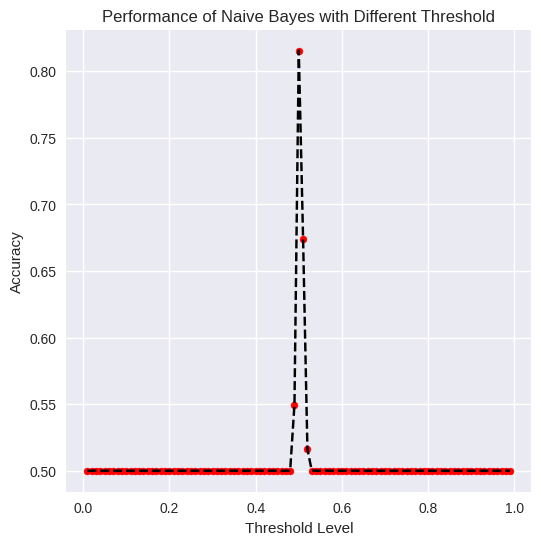

In [ ]:
#fine tuning in naive bayes
#change threshold from 0.01 to 0.99

#def predict(self,x,threshold=0.5)

model=naive_bayes()
model.fit(xtrain_vec,ytrain)

x_values = []
y_values = []
threshold = 0.01

while threshold < 1:
  ypred=model.predict(xtest_vec, threshold)
  x_values.append(threshold)
  threshold += 0.01
  acc = model.evaluate_acc(ypred,ytest)
  y_values.append(acc)

plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x_values, y_values, color = 'black',
         linestyle = 'dashed')
  
plt.scatter( x_values, y_values, marker = 'o', s = 25, color = 'red')

plt.title('Performance of Naive Bayes with Different Threshold')
plt.xlabel('Threshold Level')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
#BERT
#when ntrain and ntest is 5000 (fine-tuning process will be used with 20% of data, low resources)

#changing # of layers (1 Layer vs 2 Layers)

#1 layer 0.83
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
print(classification_report(ytest[:n_test],ypred1))

In [ ]:
accuracy = x.history['val_accuracy']
y_values = accuracy

In [ ]:
#2 layers 0.81

mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(32,activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x1 = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
print(classification_report(ytest[:n_test],ypred1))

In [ ]:
accuracy1 = x1.history['val_accuracy']
y_values1 = accuracy1

In [ ]:
x_values = []
i=1
while i <= 100:
  x_values.append(i)
  i+=1

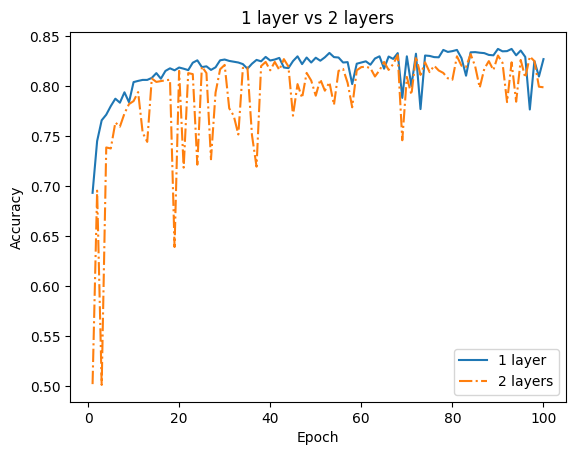

In [ ]:
plt.plot(x_values, y_values, label = '1 layer')
plt.plot(x_values, y_values1, '-.', label = '2 layers')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('1 layer vs 2 layers')
plt.show()

In [ ]:
#changing activation functions
#BERT
#when ntrain and ntest is 5000 (fine-tuning process will be used with 20% of data, low resources)

#sigmoid
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
print(classification_report(ytest[:n_test],ypred1))

In [ ]:
accuracy = x.history['val_accuracy']
y_values = accuracy

In [ ]:
#tanh
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='tanh'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x1 = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
print(classification_report(ytest[:n_test],ypred1))

In [ ]:
accuracy1 = x1.history['val_accuracy']
y_values1 = accuracy1

In [ ]:
#relu
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x2 = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
print(classification_report(ytest[:n_test],ypred1))

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      2505
           1       0.78      0.90      0.84      2495

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



In [ ]:
accuracy2 = x2.history['val_accuracy']
y_values2 = accuracy2

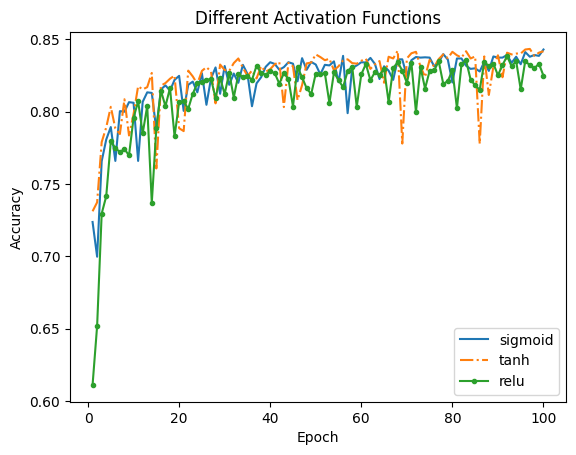

In [ ]:
plt.plot(x_values, y_values, label = 'sigmoid')
plt.plot(x_values, y_values1, '-.', label = 'tanh')
plt.plot(x_values, y_values2, '.-', label = 'relu')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Different Activation Functions')
plt.show()

In [ ]:
#Best number of neurons/dropout

neurons = 32
dropout = 0.25

scores = []

for i in range(3):
  dropout = 0.25
  for j in range(3):
    mlp = Sequential()
    mlp.add(Dense(neurons, input_shape=(768,), activation='sigmoid'))
    mlp.add(Dropout(dropout))

    mlp.add(Dense(1, activation='sigmoid'))
    # Compile model
    mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    x = mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
    ypred1=mlp.predict(xtest_poolsmall)>0.5
    scores.append(accuracy_score(ytest[:n_test],ypred1))

    dropout = dropout + 0.25

  neurons = neurons*2

In [ ]:
scores

[0.841, 0.832, 0.8294, 0.8452, 0.8246, 0.8304, 0.84, 0.8398, 0.8344]

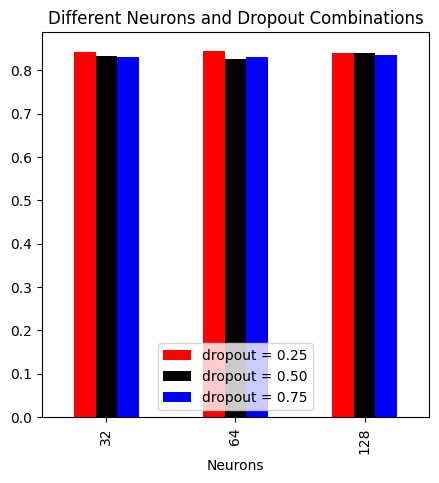

In [ ]:
data=[["32",0.841, 0.832, 0.8294],
      ["64",0.8452, 0.8246, 0.8304],
      ["128",0.84, 0.8398, 0.8344]]

colour =['red', 'black','blue']
 

df1 = pd.DataFrame(data,columns=["Neurons", "dropout = 0.25", "dropout = 0.50", "dropout = 0.75"])
 
df1.plot(x="Neurons", y=["dropout = 0.25", "dropout = 0.50", "dropout = 0.75"], kind="bar",figsize=(5,5), color = colour)

plt.title('Different Neurons and Dropout Combinations')

plt.show()

In [ ]:
#changing batch size
a = []
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.25))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
a.append(accuracy_score(ytest[:n_test],ypred1))

In [ ]:
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.25))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=32,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
a.append(accuracy_score(ytest[:n_test],ypred1))

In [ ]:
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.25))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=64,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
a.append(accuracy_score(ytest[:n_test],ypred1))

In [ ]:
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.25))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(xtrain_poolsmall, ytrain[:n_train],batch_size=128,epochs=100,validation_data=(xtest_poolsmall[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_poolsmall)>0.5
a.append(accuracy_score(ytest[:n_test],ypred1))

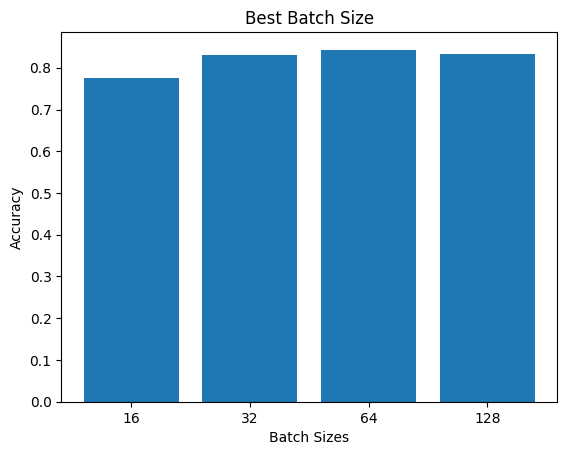

In [ ]:
x_axis = ['16', '32', '64', '128']
y_axis = a

plt.bar(x_axis, y_axis)
plt.title('Best Batch Size')
plt.xlabel('Batch Sizes')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#So best MLP is...
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='sigmoid'))
mlp.add(Dropout(0.25))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.fit(xtrain_pool, ytrain[:n_train],batch_size=64,epochs=100,validation_data=(xtest_pool[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_pool)>0.5
a.append(accuracy_score(ytest[:n_test],ypred1))

In [ ]:
#Accuracy
np.mean(ypred==ytest)

In [ ]:
print(classification_report(ytest,ypred))

In [ ]:
# DIFF LOSS FUNCTIONS
mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])

x = mlp.fit(xtrain_pool, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_pool[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_pool)>0.5
print(classification_report(ytest[:n_test],ypred1))


accuracy = x.history['val_accuracy']
y_values = accuracy

mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

x1 = mlp.fit(xtrain_pool, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_pool[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_pool)>0.5
print(classification_report(ytest[:n_test],ypred1))

accuracy1 = x1.history['val_accuracy']
y_values1 = accuracy1

mlp = Sequential()
mlp.add(Dense(64, input_shape=(768,), activation='relu'))
mlp.add(Dropout(0.5))

mlp.add(Dense(1, activation='sigmoid'))
# Compile model
mlp.compile(loss='squared_hinge', optimizer='adam', metrics=['accuracy'])

x2 = mlp.fit(xtrain_pool, ytrain[:n_train],batch_size=16,epochs=100,validation_data=(xtest_pool[:n_test], ytest[:n_test]),shuffle=True)
ypred1=mlp.predict(xtest_pool)>0.5
print(classification_report(ytest[:n_test],ypred1))


accuracy2 = x2.history['val_accuracy']
y_values2 = accuracy2

import matplotlib.pyplot as plt
x_values = []
i=1
while i <= 100:
  x_values.append(i)
  i+=1
plt.plot(x_values, y_values, label = 'cross entropy')
plt.plot(x_values, y_values1, '-.', label = 'hinge')
plt.plot(x_values, y_values2, '-.', label = 'squared-hinge')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Different Loss Functions Effect on Accuracy')
plt.show()

In [ ]:
# ATTENTION MATRIX

from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

# Define input text
# Get the attention matrix for a correctly predicted document
correct_text = "This movie was amazing. The acting was superb and the plot was engaging."


# Get the attention matrix for an incorrectly predicted document
incorrect_text = "I absolutely loved this movie. The plot was so original and the acting was top-notch. I especially enjoyed the part where the main character fell asleep for half an hour. Truly riveting stuff."


# Tokenize input text
input_ids = tokenizer.encode(correct_text, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Get model outputs
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

# Get attention matrix for the last layer
attention_matrix_c = outputs.attentions[-1][0]

# Get attention scores for CLS token
cls_attention = attention_matrix_c[0, 0]

# Reshape cls_attention matrix
cls_attention = cls_attention.view(-1, len(tokens))

# Plot heatmap
sns.heatmap(cls_attention.detach().numpy(), xticklabels=tokens, yticklabels=['CLS'], cmap='Blues')
plt.show()


# Tokenize input text
input_ids = tokenizer.encode(incorrect_text, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Get model outputs
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

# Get attention matrix for the last layer
attention_matrix_c = outputs.attentions[-1][0]

# Get attention scores for CLS token
cls_attention = attention_matrix_c[0, 0]

# Reshape cls_attention matrix
cls_attention = cls_attention.view(-1, len(tokens))

# Plot heatmap
sns.heatmap(cls_attention.detach().numpy(), xticklabels=tokens, yticklabels=['CLS'], cmap='Blues')
plt.show()

In [ ]:
#BERT PRETRAIN BASELINE
pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

import tensorflow as tf
import pandas as pd

URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

In [ ]:
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(8).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(8)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=1, validation_data=validation_data)

res=model.evaluate(validation_data)
a = model.predict(validation_data)

In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'I absolutely loved this movie. The plot was so original and the acting was top-notch. I especially enjoyed the part where the main character fell asleep for half an hour. Truly riveting stuff']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])


## EXTRA

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
xtrain_pool1=np.zeros(shape=(n_train,768))
xtest_pool1=np.zeros(shape=(n_test,768))
for i in range(n_train//100):
  preprocessed_train = bert_preprocess(xtrain[i*100:(i+1)*100])
  encoded_train = bert_encoder(preprocessed_train)
  xtrain_pool1[i*100:(i+1)*100] = encoded_train["pooled_output"]
  print(i)

for i in range(n_test//100):
  preprocessed_test= bert_preprocess(xtest[i*100:(i+1)*100])
  encoded_test = bert_encoder(preprocessed_test)
  xtest_pool1[i*100:(i+1)*100] = encoded_test["pooled_output"]
  print(i)

